## Add AttnPacker to your `PYTHONPATH`

In [1]:
import os
import sys
code_root = os.path.dirname(os.path.dirname(os.getcwd()))
if code_root not in sys.path:
    print(f"Added {code_root} to python path")
    sys.path.append(code_root)
# Faster Inference on CPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['OMP_NUM_THREADS'] = '4'


In [2]:
import torch
from protein_learning.models.inference_utils import (
    Inference,
    make_predicted_protein,
    default
)
import protein_learning.common.protein_constants as pc
import time

# Inference Procedure

### Load the model

The `Inference` class is a wrapper around the AttnPacker Model and is used for performing inference

You should have already downloaded the pretrained model weights and configs ([linked here](https://zenodo.org/record/7559358#.Y83tYuzMI0Q)). To load AttnPacker or AttnPacker+Design, 
specify the directory you downloaded these files to in the parameter `RESOURCE_ROOT`.

In [3]:
RESOURCE_ROOT = "/Users/matthewmcpartlon/Downloads/fbb_design_ft_inference/AttnPackerPTM_V2/"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# Wrapper class for inference
runner = Inference(RESOURCE_ROOT, use_design_variant = False)
runner = runner.to(DEVICE)

[INFO] Initializing AttnPacker Model


### Run Inference

When `post_process=True` the output of `runner.infer` is a dictionary with keys:

- pred_coords (Tensor[L,37,3])
    - Predicted coordinates (order is given by pc.ALL_ATOM_POSNS)
- pred_seq_logits (Tensor[L,21]) 
    - Residue-Type log likelihoods. Output only when using design variant (Order Given by pc.AA_TO_INDEX)
- pred_plddt (Tensor[L])
    - Predicted per-residue side-chain lDDT scores
- res_output (Tensor[L,L,d_pair])
    - Raw Residue Feature Output 
- pair_output (Tensor[L,d_res])
    - Raw Pair Feature output
- design_mask (Tensor[L]) 
    - Masked residue positions in input sequence (used only with design variant)
- seq (str)
    - String Representaion of Protein Sequence (possibly designed)
- model_out (common.data.data_types.model_output.ModelOutput)
    - Raw output of model.forward()
- model_in (common.data.data_types.model_output.ModelInput)
    - Raw Input to model.forward()
    
Note: The First Forward pass may be slow as the model has not yet been initialized

In [4]:
pdb_path = "./pdbs/T0967.pdb"
start = time.time()
prediction = runner.infer(
    pdb_path=pdb_path, 
    #Boolean Tensor indicating which residues to design
    design_mask=None, 
    #Whether to post-process output
    post_process=True,
    #Chunk inference by successively packing smaller crops of size chunk_size
    #This allows packing of arbitrarily long proteins
    chunk_size = 500,
)
print(f"Ran Inference on {runner.device} in time {round(time.time()-start,2)} seconds")


[INFO] Initializing AttnPacker Model


/Users/matthewmcpartlon/miniconda3/envs/attnpacker/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/matthewmcpartlon/miniconda3/envs/attnpacker/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Ran Inference on cpu in time 1.48 seconds


### Save and Analyze Predictions

Convert prediction into a `Protein` object (`common.data.data_types.protein.Protein`) before saving to PDB 

In [5]:
predicted_protein = make_predicted_protein(model_out = prediction['model_out'], seq = prediction['seq'])
# Save predicted PDB to this location
pdb_out_path = f"./attnpacker_inference/examples/{predicted_protein.name}_packed.pdb"
print(f"saving pdb to {pdb_out_path}")
predicted_protein.to_pdb(pdb_out_path)

saving pdb to ./attnpacker_inference/examples/T0967_packed.pdb


## Run Post-Processing Procedure on Output

As mentioned in the paper, the direct coordinate predictions may not have ideal geometry and
could contain some clashes (though, often the number of clashes is small!)

We can run the post-processing procedure described in the paper to fix this.


In [6]:
def project_coords_to_rotamers(
    protein,
    steric_clash_weight=1.,
    optim_repeats=2,
    max_optim_iters=100,
    steric_loss_kwargs=None,
):
    projected_coords, _ = project_onto_rotamers(
        atom_coords = protein.atom_coords.unsqueeze(0),
        sequence = protein.seq_encoding.unsqueeze(0),
        atom_mask = protein.atom_masks.unsqueeze(0),
        steric_clash_weight=steric_clash_weight,
        optim_repeats = optim_repeats,
        steric_loss_kwargs = default(
            steric_loss_kwargs, 
            dict(
                hbond_allowance = 0.6,
                global_allowance = 0.05,
                global_tol_frac = 0.95,
            )
        ),
        device = DEVICE,
        # set this to smaller value to trade off accuracy and speed.
        # use >= 500 for highest accuracy and ~50 for speed.
        max_optim_iters = max_optim_iters,
    )
    return projected_coords.squeeze(0)

In [7]:
from protein_learning.protein_utils.sidechains.project_sidechains import project_onto_rotamers
# save optimized packing to the path below
pp_pdb_out_path = f"./attnpacker_inference/examples/{predicted_protein.name}_packed_pp.pdb"

#Please read the doc string for more details
projected_coords = project_coords_to_rotamers(predicted_protein)
# write new pdb using optimized coordinates
predicted_protein.to_pdb(pp_pdb_out_path, coords=projected_coords)


/Users/matthewmcpartlon/miniconda3/envs/attnpacker/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


[fn: project_onto_rotamers] : Using device cpu
[INFO] Beginning rotamer projection
[INFO] Initial loss values
   [RMSD loss] = 0.237
   [Steric loss] = 1.219
   [Angle Dev. loss] = 0.0

beginning iter: 0, steric weight: 1.0
beginning iter: 1, steric weight: 1.0
[INFO] Final Loss Values
   [RMSD loss] = 0.17
   [Steric loss] = 0.0
   [Angle Dev. loss] = 0.015



## Analyze predicted plDDT

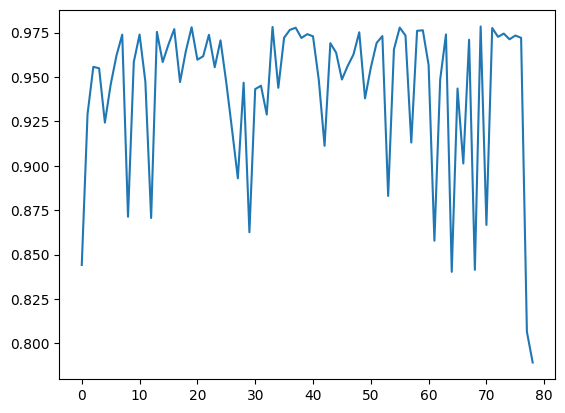

In [8]:
import matplotlib.pyplot as plt
pred_plddt = prediction["pred_plddt"]
plt.plot(torch.arange(pred_plddt.numel()),pred_plddt.squeeze())

## Visualize Optimized Coordinates

In [9]:
view = None
try:
    import nglview as nv
    view = nv.show_file(pp_pdb_out_path)
    view.add_cartoon("protein",color_scheme='residue_index')
    view.add_ball_and_stick("protein")
except:
    pass
view

# Run Inference with Design Variant

To design sequence and side-chains, just initialize the Inference class with `use_design_variant = True`, and use the `design_mask` parameter to indicate which parts of the backbone should be designed.

In [10]:
RESOURCE_ROOT = "/Users/matthewmcpartlon/Downloads/fbb_design_ft_inference/AttnPackerPTM_V2/"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# Wrapper class for inference
runner = Inference(RESOURCE_ROOT, use_design_variant = True)
runner = runner.to(DEVICE)

[INFO] Initializing AttnPacker Model


In [11]:
pdb_path = "./pdbs/T0967.pdb"
# this pdb has 79 residues
design_mask = torch.ones(79).bool() # design entire backbone sequence and sidechains
prediction = runner.infer(
    pdb_path=pdb_path, 
    #Boolean Tensor indicating which residues to design
    design_mask=design_mask, 
    #Whether to post-process output
    post_process=True
)

[INFO] Initializing AttnPacker Model


/Users/matthewmcpartlon/miniconda3/envs/attnpacker/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/matthewmcpartlon/miniconda3/envs/attnpacker/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


## Check out sequence Prediction

In [12]:
import math
pred_protein = make_predicted_protein(prediction["model_out"], seq = prediction["seq"])
x,y = prediction["model_out"].decoy_protein.seq, pred_protein.seq

print("Input Sequence :\n",x,"\n")
print("Predicted Sequence :\n",y,"\n")
aln="".join([" " if x[i]!=y[i] else "|" for i in range(len(x))])
nsr = sum([int(a==b) for a,b in zip(x,y)])/len(x)
print(f"Aligned: (NSR={round(nsr*100,1)}%)")
for i in range(math.ceil(len(x)/80)):
    s,e = i*80, (i+1)*80
    print(f" {x[s:e]}\n {aln[s:e]}\n {y[s:e]}\n")


Input Sequence :
 EDYIEAIANVLEKTPSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE 

Predicted Sequence :
 SSTVAEIEAVLEKLPAIVDIKEIEARKDGDVLHFEIEVEVPPDITEEQGEEIKAKVTEIVKEIVKEEVEVEVKLYDREL 

Aligned: (NSR=46.8%)
 EDYIEAIANVLEKTPSISDVKDIIARELGQVLEFEIDLYVPPDITVTTGERIKKEVNQIIKEIVDRKSTVKVRLFAAQE
       |  |||| | | | | | ||  | || |||   ||||||   || ||  |  | ||||     | | |     
 SSTVAEIEAVLEKLPAIVDIKEIEARKDGDVLHFEIEVEVPPDITEEQGEEIKAKVTEIVKEIVKEEVEVEVKLYDREL



Note: you can technically impute the sidechains for *any sequence* using the function below, not just the 
 one predicted by AttnPacker. i.e.

In [13]:
#Set every residue type to Arg.
pred_protein = make_predicted_protein(prediction["model_out"], seq = "".join(["R"]*len(design_mask)))

# fix clashes
all_arg_coords = project_coords_to_rotamers(
    pred_protein,
    steric_loss_kwargs= dict(
        hbond_allowance = 0.5,
        global_allowance = 0.1,
        global_tol_frac = 0.9,
        p=2,
    ),
    steric_clash_weight=1.,
    optim_repeats=3,
    max_optim_iters=200,
)

pp_pdb_out_path = f"./attnpacker_inference/examples/{pred_protein.name}_all_arg_pp.pdb"
pred_protein.to_pdb(pp_pdb_out_path, coords = all_arg_coords)

[fn: project_onto_rotamers] : Using device cpu
[INFO] Beginning rotamer projection
[INFO] Initial loss values
   [RMSD loss] = 1.469
   [Steric loss] = 328.639
   [Angle Dev. loss] = 0.0

beginning iter: 0, steric weight: 1.0
beginning iter: 1, steric weight: 1.0
beginning iter: 2, steric weight: 1.0
[INFO] Final Loss Values
   [RMSD loss] = 1.38
   [Steric loss] = 0.186
   [Angle Dev. loss] = 0.129

